In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
test_data = pd.read_excel("../test_data.xlsx")

In [3]:
test_data.head()

,job_id,job_title,job_description,date_posted,company_name
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,CALL LADE ENTERPRISES PTE LTD
1,39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...,Secretary/PA,- Roles &amp; Responsibilities : Job Scope:<br...,2020-11-26,TALENT TRADER GROUP PTE. LTD.
2,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,Temporary 3-6months Admin Assistant (Office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,Confidential
3,0c170932727e0246f27feb1a5641d0e26f44d26d431be6...,Program Management,- Roles &amp; Responsibilities : Key Responsib...,2020-11-09,YASH TECHNOLOGIES SINGAPORE PTE. LIMITED
4,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,Automotive Software Engineers (C Programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,Confidential


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   job_id           3000 non-null   object        
 1   job_title        3000 non-null   object        
 2   job_description  3000 non-null   object        
 3   date_posted      3000 non-null   datetime64[ns]
 4   company_name     3000 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 117.3+ KB


In [5]:
# Define the function to plot the barchat of top 15 common words
def plot_barchat(dataframe, title, x_label, y_label, color):
    """To plot a barchat with input of details.
    The output is a barplot of barh kind"""
    dataframe.plot(kind='barh', figsize = (8,5), color = color)
    plt.xlabel(x_label, fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(y_label, fontsize = 15)
    plt.title(title, fontsize = 14, weight = 'bold');
    return plt.show()

In [6]:
# Define function of plotting barplot
def plot_barplot(dataframe, x_data, y_data, title, x_label, y_label):
    """Plot barplot with the input details and labels.
    The output is a horizontal barplot"""
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data = dataframe, y = y_data, x = x_data, orient='v', ax=ax)
    plt.xlabel(x_label, fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(y_label, fontsize = 15)
    plt.title(title, fontsize = 14, weight = 'bold');
    return plt.show()

## Company name

In [7]:
test_data[test_data.company_name == "Confidential"].shape

(1516, 5)

In [8]:
company_confidential = test_data[test_data.company_name == "Confidential"]
company_confidential = company_confidential.reset_index(drop = True)

In [9]:
company_confidential.job_title = company_confidential.job_title.str.replace(".", "").str.lower()

In [10]:
trial = company_confidential.job_title.str.rsplit(" - ", n=2, expand = True)

In [11]:
trial.head()

,0,1,2
0,temporary 3-6months admin assistant (office ho...,jobstudio pte ltd,None
1,automotive software engineers (c programming /...,ideals recruitment pte ltd,None
2,qa / qc manager (construction) (dredging) (2 y...,rs recruitment agency llp,None
3,executive officer,muslimin trust fund association,None
4,1 year contract general ledger executive assis...,recruit express pte ltd,None


In [12]:
for index in range(len(trial)):
    if trial[2][index] == None:
        if trial[1][index] == None:
            continue
        else:
            company_confidential.loc[[index], ["company_name"]] = trial[1][index]
            trial[1][index] = None
    elif len(trial[2][index].split(" ")) > 1:
        if 'ltd' in trial[1][index] or (('national' in trial[1][index]) and ('international' not in trial[1][index])) or 'limited' in trial[1][index] or 'llp' in trial[1][index] or 'hospital'in trial[1][index]:
            company_confidential.loc[[index], ["company_name"]] = trial[1][index]
            trial[2][index] = None
            trial[1][index] = None
        else:
            company_confidential.loc[[index], ["company_name"]] = trial[2][index]
            trial[2][index] = None
            trial[1][index] = None
    elif len(trial[2][index].split(" ")) == 1:
        if 'ltd' in trial[1][index] or (('national' in trial[1][index]) and ('international' not in trial[1][index])) or 'limited' in trial[1][index] or 'llp' in trial[1][index] or 'hospital'in trial[1][index]:
            company_confidential.loc[[index], ["company_name"]] = trial[1][index]
            trial[2][index] = None
            trial[1][index] = None

In [13]:
trial.loc[(trial[1].notnull()), [1,2]]

,1,2
323,business support,singapore
433,randstad,corporate
552,gmp technologies,engineering
1152,randstad,accounting
1438,gmp technologies,engineering
1491,12 month,dupont


In [14]:
# Manually for len(word) == 1
company_confidential.loc[[433], ["company_name"]] = trial[1][433]
company_confidential.loc[[552], ["company_name"]] = trial[1][552]
company_confidential.loc[[1152], ["company_name"]] = trial[1][1152]
company_confidential.loc[[1438], ["company_name"]] = trial[1][1438]
company_confidential.loc[[1491], ["company_name"]] = trial[2][1491]

In [15]:
company_confidential.company_name[[433,552,1152,1438,1491]]

433             randstad
552     gmp technologies
1152            randstad
1438    gmp technologies
1491              dupont
Name: company_name, dtype: object

In [16]:
trial.loc[[433,552,1152,1438,1491], [1,2]] = None

In [17]:
trial.loc[(trial[1].notnull()), [1,2]]

,1,2
323,business support,singapore


### To check the validity of company name that occurs once

In [18]:
# Create dataframe of company_name frequency = 1
low_jobs_postings = company_confidential.company_name[~(company_confidential.company_name.str.contains("ltd") | company_confidential.company_name.str.contains("limited"))].value_counts()[company_confidential.company_name[~(company_confidential.company_name.str.contains("ltd") | company_confidential.company_name.str.contains("limited"))].value_counts()<2].reset_index().drop("company_name", axis = 1).rename(columns = {"index": "company_name"})

In [19]:
low_jobs_postings.head()

,company_name
0,tsao foundation
1,22k per month ✪
2,sathya sai social service
3,lighthouse evangelism
4,netlink trust


### To collect a removal list

In [20]:
# To check for numbers at the start and symbols+numbers
reg_exp = r'^\W+\d+|^\d+'
symbols = low_jobs_postings['company_name'].apply(lambda x:re.findall(reg_exp,x))
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]]

[(['22'], 1), (['$1950'], 65), (['6'], 119), (['$15'], 120)]

In [21]:
removal_list = low_jobs_postings.loc[[1, 65, 119, 120], ["company_name"]]
low_jobs_postings = low_jobs_postings.drop([1, 65, 119, 120]).reset_index(drop=True)
removal_list

,company_name
1,22k per month ✪
65,$1950
119,6 months / banking -
120,$15k / mth; p/t sales reps!!!


In [22]:
# To check for symbols /, -
reg_exp = r'\-|\/'
symbols = low_jobs_postings['company_name'].apply(lambda x:re.findall(reg_exp,x))
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]]

[(['/'], 17),
 (['-'], 57),
 (['-'], 62),
 (['-'], 69),
 (['-'], 102),
 (['-'], 103),
 (['-'], 112)]

In [23]:
low_jobs_postings

,company_name
0,tsao foundation
1,sathya sai social service
2,lighthouse evangelism
3,netlink trust
4,waterstone consulting
5,pwp group
6,the farrer park company
7,petracarbon
8,qoo10 singapore
9,singapore red cross society


In [24]:
removal_list = removal_list.append(low_jobs_postings.loc[[17, 57, 62], ["company_name"]])
low_jobs_postings = low_jobs_postings.drop([17, 57, 62]).reset_index(drop=True)
removal_list

,company_name
1,22k per month ✪
65,$1950
119,6 months / banking -
120,$15k / mth; p/t sales reps!!!
17,part time / full time
57,maid agency) -
62,flexible hours & good pay -


In [25]:
# To separate them into word length
low_jobs_postings["word_length"] = low_jobs_postings.company_name.apply(lambda x: len(x.split(" ")))

In [26]:
# To check if the company_names word length more than 2 are valid
low_jobs_postings[low_jobs_postings.word_length>2].head()

,company_name,word_length
1,sathya sai social service,4
6,the farrer park company,4
9,singapore red cross society,4
10,global trading company,3
12,singapore art museum,3


In [27]:
# To check if the company_names word length less than 2 are valid
low_jobs_postings[low_jobs_postings.word_length<=2]

,company_name,word_length
0,tsao foundation,2
2,lighthouse evangelism,2
3,netlink trust,2
4,waterstone consulting,2
5,pwp group,2
7,petracarbon,1
8,qoo10 singapore,2
11,forty forty,2
20,white restaurant,2
21,christopher loh,2


In [28]:
removal_list = removal_list.append(low_jobs_postings.loc[[41, 76, 92, 113], ["company_name"]])
low_jobs_postings = low_jobs_postings.drop([41, 76, 92, 113]).reset_index(drop=True)
removal_list

,company_name
1,22k per month ✪
65,$1950
119,6 months / banking -
120,$15k / mth; p/t sales reps!!!
17,part time / full time
57,maid agency) -
62,flexible hours & good pay -
41,bedok
76,central
92,apac


In [30]:
low_jobs_postings[low_jobs_postings.word_length<=2]

,company_name,word_length
0,tsao foundation,2
2,lighthouse evangelism,2
3,netlink trust,2
4,waterstone consulting,2
5,pwp group,2
7,petracarbon,1
8,qoo10 singapore,2
11,forty forty,2
20,white restaurant,2
21,christopher loh,2


In [31]:
# Manually input
company_confidential.loc[[150], ["company_name"]] = "professional investment advisory services - christopher loh"
company_confidential.loc[[285], ["company_name"]] = 'ikea tampines'
company_confidential.loc[[348], ["company_name"]] = "yuli inc - fine jewellery"
low_jobs_postings = low_jobs_postings.drop([21, 27, 34]).reset_index(drop=True)

In [32]:
removal_list = removal_list.company_name.tolist()

In [33]:
for index in range(len(company_confidential.company_name)):
    if company_confidential.company_name[index] in removal_list:
        company_confidential.loc[[index], ["company_name"]] = "Confidential"

### To check for company_name for symbols

In [34]:
company_confidential.loc[(company_confidential.company_name!= "Confidential"), ["company_name"]].head()

,company_name
0,jobstudio pte ltd
1,ideals recruitment pte ltd
2,rs recruitment agency llp
3,muslimin trust fund association
4,recruit express pte ltd


In [35]:
# To check for symbols /, -
reg_exp = r'\-|\/|\&'
symbols = company_confidential['company_name'].apply(lambda x:re.findall(reg_exp,x))
[(symbols[i], i, company_confidential['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['-'], 99, 'tele-centre services pte ltd'),
 (['-'], 112, 'hi-p international limited'),
 (['&', '-'],
  121,
  'sentosa development corporation & subsidiaries (part-time)'),
 (['-'], 150, 'professional investment advisory services - christopher loh')]

In [36]:
company_confidential.loc[[121],["company_name"]] = company_confidential.loc[[121],["company_name"]].replace(" (part-time)", "")

In [37]:
company_confidential["division"] = np.nan

In [38]:
for index in range(len(company_confidential.company_name)):
    if company_confidential.company_name[index] == "capita pte ltd – temp & contract":
        company_confidential.loc[[index],["company_name"]] = 'capita pte ltd'
        company_confidential.loc[[index], ["division"]] = "temp & contract"

In [39]:
company_confidential.company_name[company_confidential.company_name.str.contains("capita pte ltd")].unique()

array(['capita pte ltd',
       'persol singapore (a division of capita pte ltd)'], dtype=object)

In [40]:
company_confidential.head()

,job_id,job_title,job_description,date_posted,company_name,division
0,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,temporary 3-6months admin assistant (office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,jobstudio pte ltd,NaN
1,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,automotive software engineers (c programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,ideals recruitment pte ltd,NaN
2,0e2237ae429ed3e93cebe3a77be1ee71b45400b7259c65...,qa / qc manager (construction) (dredging) (2 y...,MNC<br/>2 years contract<br/>Good benefits<br/...,2020-11-27,rs recruitment agency llp,NaN
3,9df231dea41ab31676809589715e2520a603f074ab14dd...,executive officer - muslimin trust fund associ...,Responsibilities:<br/><br/>Executing administr...,2020-11-27,muslimin trust fund association,NaN
4,1841d7ef254cfc426b3158cf05541953864acd0145ceb7...,1 year contract general ledger executive assis...,Job Scope:<br/>Handle day-to-day financial mat...,2020-11-15,recruit express pte ltd,NaN


### To check for company_name for null and confidential

In [41]:
query_company = company_confidential[company_confidential['company_name'] == "Confidential"].reset_index(drop=True)

In [42]:
query_company.shape

(141, 6)

In [43]:
query_company.head()

,job_id,job_title,job_description,date_posted,company_name,division
0,e74521a5be72280b591d59d49c80f0df464cc690adedc9...,"analyst, data -",ResponsibilitiesDive into data sets affecting ...,2020-11-22,Confidential,NaN
1,f4a814b42728c6e8568e1fdb8ea576d9b7bc298e20fe10...,"⚡sweets packer @ west (start asap, min 3 month...","⚡Sweets Packer @ West (START ASAP, Min 3 month...",2020-11-20,Confidential,NaN
2,551b9831be1a5a292dc3cb5002b5521a4def33e433c667...,senior / software engineer -,Responsibilities:<br/><br/>Develop and enhance...,2020-11-11,Confidential,NaN
3,f2769f5cee61c3519fdef74454367a9d5715083efb9207...,formwork supervisor (rc structural works) -,Responsibilities<br/><br/>To supervise and man...,2020-11-21,Confidential,NaN
4,5b120b5f00be814d19b68ba47ce7498e57a76af5bb8ad3...,hr executive cum purchaser -,Responsibilities:<br/>Assisting in full spectr...,2020-11-10,Confidential,NaN


In [44]:
tokenizer_1 = RegexpTokenizer('<br\/>>|<br\/>|\]|\||\.', gaps=True)

# Run tokenizer.
for number in range(len(query_company['job_description'])):
    tokenized_paragraph = tokenizer_1.tokenize(query_company.job_description[number])
    for word in tokenized_paragraph:
        if "pte ltd" in word.lower():
            query_company.loc[[number],['company_name']] = word.lower()

In [45]:
query_company[query_company['company_name'] != "Confidential"].shape

(23, 6)

In [46]:
reg_exp = r'([a-z]+).(pte).(ltd)|([a-z]+).([a-z]+).(pte).(ltd)|([a-z]+).([a-z]+).([a-z]+).(pte).(ltd)|([a-z]+).([a-z]+).([a-z]+).([a-z]+).(pte).(ltd)'
symbols = query_company['company_name'].str.lower().apply(lambda x:re.findall(reg_exp,x))
symbols_list = [(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]]

In [47]:
len(symbols_list)

22

In [48]:
query_company["company_name_extract"] = np.nan

In [49]:
for i in range(len(symbols_list)):
    query_company.loc[[symbols_list[i][1]],["company_name_extract"]] = " ".join(symbols_list[i][0][0]).strip()

In [50]:
query_company[query_company['company_name'] != "Confidential"].shape

(23, 7)

In [51]:
query_company.loc[[29],['company_name_extract']] = query_company['company_name'][29]
query_company.loc[[38],['company_name_extract']] = query_company['company_name_extract'][38].replace("including ", "")
query_company.loc[[102],['company_name_extract']] = query_company['company_name_extract'][102].replace("gkmy ", "")

In [52]:
query_company.head()

,job_id,job_title,job_description,date_posted,company_name,division,company_name_extract
0,e74521a5be72280b591d59d49c80f0df464cc690adedc9...,"analyst, data -",ResponsibilitiesDive into data sets affecting ...,2020-11-22,Confidential,NaN,NaN
1,f4a814b42728c6e8568e1fdb8ea576d9b7bc298e20fe10...,"⚡sweets packer @ west (start asap, min 3 month...","⚡Sweets Packer @ West (START ASAP, Min 3 month...",2020-11-20,rapid recruitment asia pte ltd,NaN,rapid recruitment asia pte ltd
2,551b9831be1a5a292dc3cb5002b5521a4def33e433c667...,senior / software engineer -,Responsibilities:<br/><br/>Develop and enhance...,2020-11-11,Confidential,NaN,NaN
3,f2769f5cee61c3519fdef74454367a9d5715083efb9207...,formwork supervisor (rc structural works) -,Responsibilities<br/><br/>To supervise and man...,2020-11-21,Confidential,NaN,NaN
4,5b120b5f00be814d19b68ba47ce7498e57a76af5bb8ad3...,hr executive cum purchaser -,Responsibilities:<br/>Assisting in full spectr...,2020-11-10,Confidential,NaN,NaN


In [53]:
query_company[query_company['company_name'] == "Confidential"].head()

,job_id,job_title,job_description,date_posted,company_name,division,company_name_extract
0,e74521a5be72280b591d59d49c80f0df464cc690adedc9...,"analyst, data -",ResponsibilitiesDive into data sets affecting ...,2020-11-22,Confidential,NaN,NaN
2,551b9831be1a5a292dc3cb5002b5521a4def33e433c667...,senior / software engineer -,Responsibilities:<br/><br/>Develop and enhance...,2020-11-11,Confidential,NaN,NaN
3,f2769f5cee61c3519fdef74454367a9d5715083efb9207...,formwork supervisor (rc structural works) -,Responsibilities<br/><br/>To supervise and man...,2020-11-21,Confidential,NaN,NaN
4,5b120b5f00be814d19b68ba47ce7498e57a76af5bb8ad3...,hr executive cum purchaser -,Responsibilities:<br/>Assisting in full spectr...,2020-11-10,Confidential,NaN,NaN
5,5aa573125c67b8518588b4e5b35b50e3015beccbc4fdeb...,costing accountant (cambodia),Experiences in Manufacturing industry &acirc;&...,2020-11-19,Confidential,NaN,NaN


In [54]:
query_company.loc[(query_company.company_name_extract.isnull()), ["company_name_extract"]] = "Confidential"

In [55]:
query_company = query_company.drop(["company_name"], axis = 1)
query_company = query_company.rename({"company_name_extract":"company_name"}, axis = 1)

In [56]:
query_company.head()

,job_id,job_title,job_description,date_posted,division,company_name
0,e74521a5be72280b591d59d49c80f0df464cc690adedc9...,"analyst, data -",ResponsibilitiesDive into data sets affecting ...,2020-11-22,NaN,Confidential
1,f4a814b42728c6e8568e1fdb8ea576d9b7bc298e20fe10...,"⚡sweets packer @ west (start asap, min 3 month...","⚡Sweets Packer @ West (START ASAP, Min 3 month...",2020-11-20,NaN,rapid recruitment asia pte ltd
2,551b9831be1a5a292dc3cb5002b5521a4def33e433c667...,senior / software engineer -,Responsibilities:<br/><br/>Develop and enhance...,2020-11-11,NaN,Confidential
3,f2769f5cee61c3519fdef74454367a9d5715083efb9207...,formwork supervisor (rc structural works) -,Responsibilities<br/><br/>To supervise and man...,2020-11-21,NaN,Confidential
4,5b120b5f00be814d19b68ba47ce7498e57a76af5bb8ad3...,hr executive cum purchaser -,Responsibilities:<br/>Assisting in full spectr...,2020-11-10,NaN,Confidential


### Merge with main dataframe

In [57]:
company_nonconfidential = company_confidential[company_confidential.company_name != "Confidential"]

In [58]:
company_confidential = pd.concat([company_nonconfidential, query_company], axis = 0).reset_index(drop=True)

In [59]:
company_confidential.head()

,job_id,job_title,job_description,date_posted,company_name,division
0,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,temporary 3-6months admin assistant (office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,jobstudio pte ltd,NaN
1,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,automotive software engineers (c programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,ideals recruitment pte ltd,NaN
2,0e2237ae429ed3e93cebe3a77be1ee71b45400b7259c65...,qa / qc manager (construction) (dredging) (2 y...,MNC<br/>2 years contract<br/>Good benefits<br/...,2020-11-27,rs recruitment agency llp,NaN
3,9df231dea41ab31676809589715e2520a603f074ab14dd...,executive officer - muslimin trust fund associ...,Responsibilities:<br/><br/>Executing administr...,2020-11-27,muslimin trust fund association,NaN
4,1841d7ef254cfc426b3158cf05541953864acd0145ceb7...,1 year contract general ledger executive assis...,Job Scope:<br/>Handle day-to-day financial mat...,2020-11-15,recruit express pte ltd,NaN


In [60]:
test_data_nonconfidential = test_data[test_data.company_name != "Confidential"]

In [61]:
test_data_df = pd.concat([test_data_nonconfidential, company_confidential], axis = 0).reset_index(drop=True)
test_data_df.shape

(3000, 6)

In [62]:
test_data_df.company_name = test_data_df.company_name.apply(lambda x: x.lower())

In [63]:
test_data_df.head()

,job_id,job_title,job_description,date_posted,company_name,division
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,call lade enterprises pte ltd,NaN
1,39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...,Secretary/PA,- Roles &amp; Responsibilities : Job Scope:<br...,2020-11-26,talent trader group pte. ltd.,NaN
2,0c170932727e0246f27feb1a5641d0e26f44d26d431be6...,Program Management,- Roles &amp; Responsibilities : Key Responsib...,2020-11-09,yash technologies singapore pte. limited,NaN
3,d9e850991db70064d3cfd30ca5d5153e37f383535999bf...,Managing Consultant,- Roles &amp; Responsibilities : PRIMARY OBJEC...,2020-11-06,michael page international pte ltd,NaN
4,e29e488f5140be0f4e3c781a4661d99765639b1ccbf017...,Lab Technician - $1700 #ERH,Local Food Manufacturing company is hiring for...,2020-11-24,recruitexpress,NaN


## Synchronization on naming system

In [64]:
test_data_df.company_name = test_data_df.company_name.str.replace(".", "")

In [65]:
# To check for remove mha - 
reg_exp = r'mha - '
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['mha - '], 568, 'central narcotics bureau (cnb)'),
 (['mha - '], 1153, 'singapore prison service (sps)')]

In [66]:
# To check for a*star and rename to a*star
reg_exp = r'a\*star'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]
num_list = [930, 970, 1336, 1515, 1859, 1944, 1975, 2119, 2236, 2340]
for num in num_list:
    test_data_df.loc[[num], ["division"]] = test_data_df.loc[[num], ["company_name"]]
test_data_df.loc[[930, 970, 1336, 1515, 1859, 1944, 1975, 2119, 2236, 2340], ['company_name']] = "a*star"

In [67]:
# To check for remove (word)
reg_exp = r'\(\w+\)'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['(s)'], 17, 'gmp technologies  pte ltd'),
 (['(sales)'], 68, 'hewlett-packard singapore  pte ltd'),
 (['(singapore)'], 70, 'optimum solutions  pte ltd'),
 (['(asia)'], 129, 'maha chemicals  pte ltd')]

In [68]:
# To remove (words)
reg_exp = r'\(\w?\W*\w+\)|\(\w.+\)'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if symbols[i][0] != '(pte ltd)':
                test_data_df.loc[[i],['division']] = symbols[i][0]
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['(allegis group singapore pte ltd)'], 31, 'teksystems'),
 (['(pte ltd)'], 39, 'sleek tech'),
 (['(deutsche europaeische schule singapur)'],
  50,
  'german european school singapore'),
 (['(pte ltd)'], 80, 'xplore infocomz solution')]

In [69]:
# To remove pte ltd with words behind
reg_exp = r'pte ltd.+'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['pte ltdmakewaypacificcom'], 121, 'makeway pacific'),
 (['pte ltditaskcomsg'], 156, 'i task'),
 (['pte ltdone-taxcom'], 182, 'one tax cm'),
 (['pte ltdtraxxbiz'], 276, 'traxx payments')]

In [70]:
# To remove ends with pte limited
reg_exp = r'pte limited$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['pte limited'], 5, 'openbet singapore'),
 (['pte limited'], 341, 'delivery hero apac'),
 (['pte limited'], 485, 'itcan'),
 (['pte limited'], 622, 'itcan')]

In [71]:
# To remove ends with private limited
reg_exp = r'private limited$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['private limited'], 126, 'sfc academy'),
 (['private limited'], 193, 'gic'),
 (['private limited'], 233, 'tripleline technologies'),
 (['private limited'], 241, 'humane manpower')]

In [72]:
# To remove ends with limited
reg_exp = r'limited$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['limited'], 72, 'singapore telecommunications'),
 (['limited'], 107, 'nanofilm technologies international'),
 (['limited'], 221, 'standard chartered bank'),
 (['limited'], 228, 'far ocean sea products')]

In [73]:
# To remove ends with pte ltd
reg_exp = r'pte ltd$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['pte ltd'], 1, 'talent trader group'),
 (['pte ltd'], 3, 'michael page international'),
 (['pte ltd'], 7, 'logistics construction'),
 (['pte ltd'], 9, 'dreamscape networks international')]

In [74]:
# To remove ends with limited (for uob)
reg_exp = r'limited$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[]

In [75]:
# To remove ends with ltd
reg_exp = r'ltd$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['ltd'], 48, 'hitachi plant services co,'),
 (['ltd'], 142, 'dbs bank'),
 (['ltd'], 159, 'st engineering aerospace'),
 (['ltd'], 166, 'dbs bank')]

In [76]:
# Acronym for banks
test_data_df.company_name = test_data_df.company_name.apply(lambda x: x.replace("kim eng securities", "").strip())
test_data_df.company_name = test_data_df.company_name.apply(lambda x: x.replace("oversea-chinese banking corporation", "ocbc bank").strip())

# To modify dbs bank
reg_exp = r'dbs$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"dbs bank",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['dbs'], 172, 'dbs bank'),
 (['dbs'], 747, 'dbs bank'),
 (['dbs'], 1212, 'dbs bank')]

In [77]:
# To modify citi bank
test_data_df.company_name = test_data_df.company_name.apply(lambda x: x.replace("citibank na", "citibank").strip())

reg_exp = r'citi$'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"citibank",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['citi'], 257, 'citibank'),
 (['citi'], 328, 'citibank'),
 (['citi'], 416, 'citibank'),
 (['citi'], 521, 'citibank')]

In [78]:
# Acronym for recruit express
test_data_df.company_name = test_data_df.company_name.apply(lambda x: x.replace("recruitexpress", "recruit express").strip())

In [79]:
# Removal ','
reg_exp = r','
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[([','], 216, 'ministry of culture community and youth'),
 ([','], 352, 'koch industries inc'),
 ([','], 661, 'koch industries inc'),
 ([','], 809, 'cloudflare')]

In [80]:
# Removal of additional spaces
reg_exp = r'\s{2,}'
symbols = test_data_df['company_name'].apply(lambda x:re.findall(reg_exp,x))
test_data_df['company_name'] = test_data_df['company_name'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, test_data_df['company_name'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['  '], 536, 'revel techholdings'),
 (['  '], 1918, 'hycinc'),
 (['  '], 2802, 'seabancinsurance brokers')]

## Repeated Job Description

In [81]:
test_data_df["index"] = test_data_df.index
test_data_df["is_duplicated_count"] = test_data_df.job_description.duplicated(keep=False).astype(int)
job_description_duplicated = test_data_df[test_data_df.is_duplicated_count == 1].reset_index(drop = True)

In [82]:
# Count the number of duplicated posts
counter = 0
duplicated_count = []

for index1, job1 in enumerate(job_description_duplicated.job_description):
    for index2, job2 in enumerate(job_description_duplicated.job_description):
        if job_description_duplicated.job_description[index1] == job_description_duplicated.job_description[index2]:
            counter+=1
    duplicated_count.extend([[job_description_duplicated["index"][index1], counter]])
    counter = 0

In [83]:
duplicated_count_df = pd.DataFrame(duplicated_count, columns = ["index", "duplicated_count"])
test_data_df = pd.merge(test_data_df, duplicated_count_df, on = "index", how = "left")
test_data_df = test_data_df.drop(columns = ["index"])
test_data_df.duplicated_count = test_data_df.duplicated_count.fillna(0).astype(int)

In [84]:
test_data_df[test_data_df.is_duplicated_count == 1].sort_values("job_description").head()

,job_id,job_title,job_description,date_posted,company_name,division,is_duplicated_count,duplicated_count
1409,ba4ab44110583ae2f5709536c22d968c828f3179b1dd0b...,"Toolmaker (North/ West, Shift)",- Roles &amp; Responsibilities : Responsibilit...,2020-11-19,recruit expert,NaN,1,2
1243,08dea3a310ce8a847f56f47598861ac117bbcdfce17c9e...,"Toolmaker (North/West, Shift)",- Roles &amp; Responsibilities : Responsibilit...,2020-11-26,recruit expert,NaN,1,2
1448,19cff651fb0bc7f851bcfbf15f01f45a7a36392fe87614...,QA/QC Technician (Manufacturing/ Semiconductor...,- Roles &amp; Responsibilities : Responsibilit...,2020-11-17,recruit expert,NaN,1,2
948,ec205e80b9141fd5909f1cd375e099d74b9042bd05f90c...,QA/QC Technician (Manufacturing/ Semiconductor...,- Roles &amp; Responsibilities : Responsibilit...,2020-11-20,recruit expert,NaN,1,2
2513,333ecd854834ced753548f728b27d326446d5a8286e079...,qc inspector [mnc/cmm/smart scope/iso 9000/shi...,A Well-Established MNC Company<br/>is looking ...,2020-11-13,persol singapore,(a division of capita pte ltd),1,2


In [85]:
duplicated_jobs_posts_df = test_data_df[test_data_df.is_duplicated_count == 1] 
duplicated_jobs_posts_df = duplicated_jobs_posts_df.reset_index(drop=True).sort_values(by=["job_description","date_posted"])

In [86]:
duplicated_jobs_posts_df.shape

(49, 8)

In [87]:
duplicated_jobs_posts_df.job_description.nunique()

24

In [88]:
duplicated_jobs_posts_df.company_name.unique()

array(['recruit expert', 'persol singapore', 'certis group',
       'employment and employability institute',
       'evolve mixed martial arts', 'central provident fund board',
       'recruit express', 'recruitplus consulting', 'koch industries inc',
       'jobsdb jobs', 'braverywf', 'kelly services', 'capita',
       'tech2reachtech2reachcom', 'ember recruitment',
       'primestaff management services', 'bloomberg', 'vital',
       'national university of singapore', 'acteco holding pte',
       'achieve career consultant'], dtype=object)

In [89]:
duplicated_jobs_posts_df.company_name.nunique()

21

In [90]:
duplicated_jobs_posts_df.head()

,job_id,job_title,job_description,date_posted,company_name,division,is_duplicated_count,duplicated_count
15,ba4ab44110583ae2f5709536c22d968c828f3179b1dd0b...,"Toolmaker (North/ West, Shift)",- Roles &amp; Responsibilities : Responsibilit...,2020-11-19,recruit expert,NaN,1,2
13,08dea3a310ce8a847f56f47598861ac117bbcdfce17c9e...,"Toolmaker (North/West, Shift)",- Roles &amp; Responsibilities : Responsibilit...,2020-11-26,recruit expert,NaN,1,2
17,19cff651fb0bc7f851bcfbf15f01f45a7a36392fe87614...,QA/QC Technician (Manufacturing/ Semiconductor...,- Roles &amp; Responsibilities : Responsibilit...,2020-11-17,recruit expert,NaN,1,2
10,ec205e80b9141fd5909f1cd375e099d74b9042bd05f90c...,QA/QC Technician (Manufacturing/ Semiconductor...,- Roles &amp; Responsibilities : Responsibilit...,2020-11-20,recruit expert,NaN,1,2
40,333ecd854834ced753548f728b27d326446d5a8286e079...,qc inspector [mnc/cmm/smart scope/iso 9000/shi...,A Well-Established MNC Company<br/>is looking ...,2020-11-13,persol singapore,(a division of capita pte ltd),1,2


In [91]:
# Create new dataframe with single posts
compile_duplicated_df = pd.DataFrame(duplicated_jobs_posts_df.job_description.unique(), columns = ["job_description"])

In [92]:
# To integrate job_title, company_name, duplicated_count and first posted date
compile_duplicated_df["date_posted_1"] = ""
compile_duplicated_df["job_title"] = ""
compile_duplicated_df["company_name"] = ""
compile_duplicated_df["duplicated_count"] = 0

for num, postings in enumerate(compile_duplicated_df.job_description):
    for index, job_posts in enumerate(duplicated_jobs_posts_df.job_description):
        if compile_duplicated_df.job_description[num] == duplicated_jobs_posts_df.job_description[index]:
            if compile_duplicated_df["date_posted_1"][num] == "":
                compile_duplicated_df.loc[[num],["job_title"]] = duplicated_jobs_posts_df["job_title"][index]
                compile_duplicated_df.loc[[num],["company_name"]] = duplicated_jobs_posts_df["company_name"][index]
                compile_duplicated_df.loc[[num],["duplicated_count"]] = duplicated_jobs_posts_df["duplicated_count"][index]
                compile_duplicated_df.loc[[num],["date_posted_1"]] = duplicated_jobs_posts_df["date_posted"][index]
                
            else:
                continue
        else:
            continue

In [93]:
# To integrate second and third posted date
compile_duplicated_df["date_posted_2"] = ""
compile_duplicated_df["date_posted_3"] = ""

for num, postings in enumerate(compile_duplicated_df.job_description):
    for index, job_posts in enumerate(duplicated_jobs_posts_df.job_description):
        if compile_duplicated_df.job_description[num] == duplicated_jobs_posts_df.job_description[index]:
            if compile_duplicated_df["date_posted_1"][num] != duplicated_jobs_posts_df["date_posted"][index]:
                if (compile_duplicated_df["date_posted_2"][num] == ""):
                    compile_duplicated_df.loc[[num],["date_posted_2"]] = duplicated_jobs_posts_df["date_posted"][index]
                else:
                    compile_duplicated_df.loc[[num],["date_posted_3"]] = duplicated_jobs_posts_df["date_posted"][index]   
            else:
                continue
        else:
            continue

In [94]:
# Fill in the duplicated post that posts on the same day
for i in range(len(compile_duplicated_df)):
    if compile_duplicated_df.date_posted_2[i] == "":
        compile_duplicated_df.loc[[i],["date_posted_2"]] = compile_duplicated_df.date_posted_1[i]

In [95]:
# To calculate the difference in dates posted
compile_duplicated_df["date_diff"] = ""

for i in range(len(compile_duplicated_df)):
    if compile_duplicated_df.date_posted_3[i] == "":
        compile_duplicated_df.loc[[i],["date_diff"]] = abs(compile_duplicated_df.date_posted_2[i] - compile_duplicated_df.date_posted_1[i])
    else:
        compile_duplicated_df.loc[[i],["date_diff"]] = abs(compile_duplicated_df.date_posted_3[i] - compile_duplicated_df.date_posted_2[i])

In [96]:
compile_duplicated_df.head()

,job_description,date_posted_1,job_title,company_name,duplicated_count,date_posted_2,date_posted_3,date_diff
0,- Roles &amp; Responsibilities : Responsibilit...,2020-11-26 00:00:00,"Toolmaker (North/West, Shift)",recruit expert,2,2020-11-19 00:00:00,,7 days 00:00:00
1,- Roles &amp; Responsibilities : Responsibilit...,2020-11-20 00:00:00,QA/QC Technician (Manufacturing/ Semiconductor...,recruit expert,2,2020-11-17 00:00:00,,3 days 00:00:00
2,A Well-Established MNC Company<br/>is looking ...,2020-11-13 00:00:00,qc inspector [mnc/cmm/smart scope/iso 9000/shi...,persol singapore,2,2020-11-19 00:00:00,,6 days 00:00:00
3,"Armed Auxiliary Police Officers (Bonus $16,000...",2020-11-21 00:00:00,"""stable career"" gross 2600 - 3600 armed office...",certis group,2,2020-11-12 00:00:00,,9 days 00:00:00
4,As Finance Executive at the Corporate Finance ...,2020-11-18 00:00:00,finance executive (e2i) - employment and emplo...,employment and employability institute,2,2020-11-12 00:00:00,,6 days 00:00:00


In [97]:
compile_duplicated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_description   24 non-null     object
 1   date_posted_1     24 non-null     object
 2   job_title         24 non-null     object
 3   company_name      24 non-null     object
 4   duplicated_count  24 non-null     int64 
 5   date_posted_2     24 non-null     object
 6   date_posted_3     24 non-null     object
 7   date_diff         24 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.6+ KB


In [98]:
# To create the dataframe of the date difference and the number of posts
compile_duplicated_df.date_diff = pd.to_timedelta(compile_duplicated_df.date_diff)
compile_duplicated_df.date_diff = compile_duplicated_df.date_diff.dt.days
duplicated_date_diff_df = compile_duplicated_df.groupby("date_diff").size().reset_index().rename({0:"posts_count"}, axis = 1)

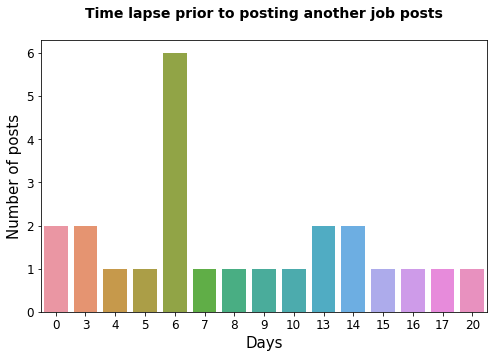

In [99]:
plot_barplot(duplicated_date_diff_df, "date_diff", "posts_count","Time lapse prior to posting another job posts\n","Days","Number of posts")

## Remove duplicated posts

In [100]:
test_data_df = test_data_df[test_data_df.is_duplicated_count == 0] 
test_data_df.shape

(2951, 8)

In [101]:
# Indicate the 2nd duplicated posts
duplicated_jobs_posts_df = duplicated_jobs_posts_df.sort_values(by=["job_description", "date_posted"]).reset_index(drop=True)
duplicated_jobs_posts_df["duplicate"] = duplicated_jobs_posts_df.job_description.duplicated().astype(int)

# Extract only the single posts and merge with the main dataframe
single_job_post_df = duplicated_jobs_posts_df[duplicated_jobs_posts_df["duplicate"] == 0]
single_job_post_df = single_job_post_df.drop("duplicate", axis = 1)
test_data_df = pd.concat([test_data_df, single_job_post_df])
test_data_df = test_data_df.reset_index(drop=True)
test_data_df.shape

(2975, 8)

## Overall

In [102]:
test_data_df[test_data_df.company_name == "confidential"].shape

(118, 8)

In [103]:
test_data_df[test_data_df.company_name != "confidential"].shape

(2857, 8)

In [104]:
companies_df = test_data_df[test_data_df.company_name != "confidential"]

In [105]:
companies_df = companies_df.reset_index(drop=True)

In [106]:
# Total number of companies
companies_df.company_name.nunique()

1413

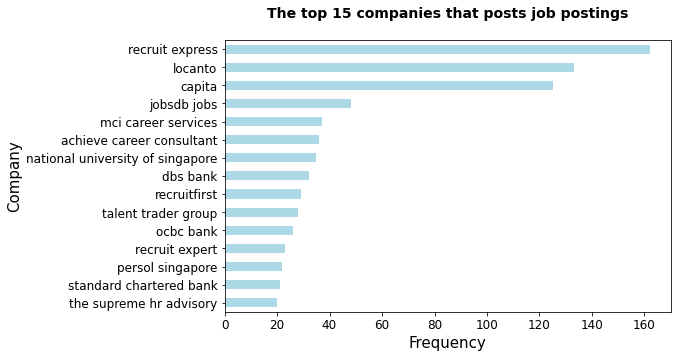

In [107]:
# Overall company
plot_barchat(companies_df.company_name.value_counts().head(15)[::-1], "The top 15 companies that posts job postings\n","Frequency","Company", 'lightblue')

## Excluding recruiters & confidential (only company)

In [108]:
recruiter_firms = ["recruit express", "locanto", "capita", "jobsdb jobs", "achieve career consultant", "mci career services", "recruitfirst", "talent trader group", "recruit expert", "persol singapore", "the supreme hr advisory", "kelly services", "people profilers", "jobstudio", "recruitplus consulting", "good job creations", "adecco personnel", "recruit express services", "ideals recruitment", "michael page", "search index", "recruitflash", "mtc staffing", "jointhire singapore", "scientec personnel", "mass power services", "hays", "trust recruit", "manpower staffing services", "staffondemand", "jte recruit", 'active hr management', "bgc group", "achieve talents", "anradus", "eps consultants", "search personnel", "teksystems", "tangspac consulting", "workle", "gmp technologies", "tempserv"]

In [109]:
companies_dfv1 = companies_df.copy()

In [110]:
companies_dfv1["recruiter"] = 0

In [111]:
companies_dfv1.head(1)

,job_id,job_title,job_description,date_posted,company_name,division,is_duplicated_count,duplicated_count,recruiter
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,call lade enterprises,NaN,0,0,0


In [112]:
companies_dfv1.shape

(2857, 9)

In [113]:
for number in range(len(companies_dfv1)):
    if companies_dfv1.company_name[number] != "":
        if companies_dfv1.company_name[number] in recruiter_firms:
            companies_dfv1.loc[[number], ["recruiter"]] = 1
    else:
        continue

In [114]:
removal_top_recruiter_df = companies_dfv1[companies_dfv1.recruiter == 0]

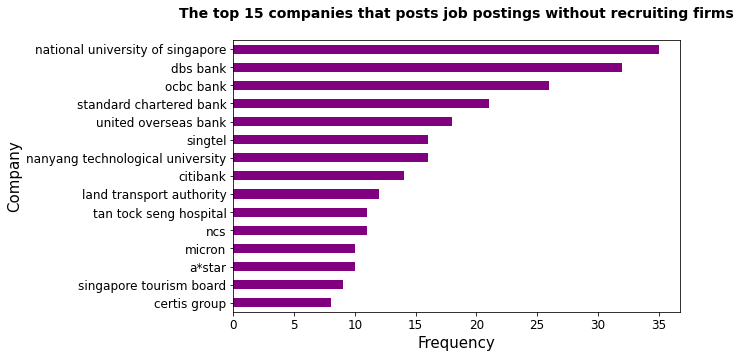

In [115]:
plot_barchat(removal_top_recruiter_df.company_name.value_counts().head(15)[::-1], "The top 15 companies that posts job postings without recruiting firms\n","Frequency","Company", 'purple')

## Time-date

In [116]:
min(test_data_df.date_posted)

Timestamp('2020-11-01 00:00:00')

In [117]:
max(test_data_df.date_posted)

Timestamp('2020-12-31 00:00:00')

In [118]:
timepost_count_df = test_data_df.groupby("date_posted").size().reset_index().rename({0:"post_count"}, axis = 1)

In [119]:
timepost_count_df["month"] = timepost_count_df.date_posted.dt.month

In [120]:
timepost_count_df.groupby("month").agg({"post_count":np.sum})

,post_count
month,
11,2932
12,43


In [121]:
timepost_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_posted  47 non-null     datetime64[ns]
 1   post_count   47 non-null     int64         
 2   month        47 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.2 KB


In [122]:
timepost_count_df = timepost_count_df.set_index("date_posted")

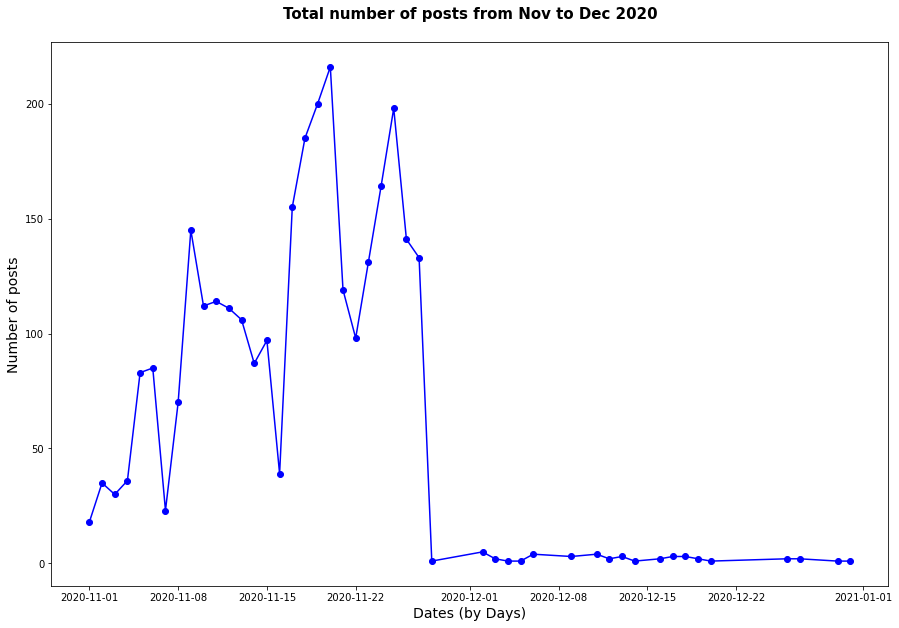

In [123]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(timepost_count_df.post_count, color = 'blue', marker = 'o')
ax.set_ylabel("Number of posts", fontsize = 14)
ax.set_xlabel("Dates (by Days)", fontsize = 14)
plt.title(("Total number of posts from Nov to Dec 2020" +"\n"), weight = 'bold', fontsize = 15);

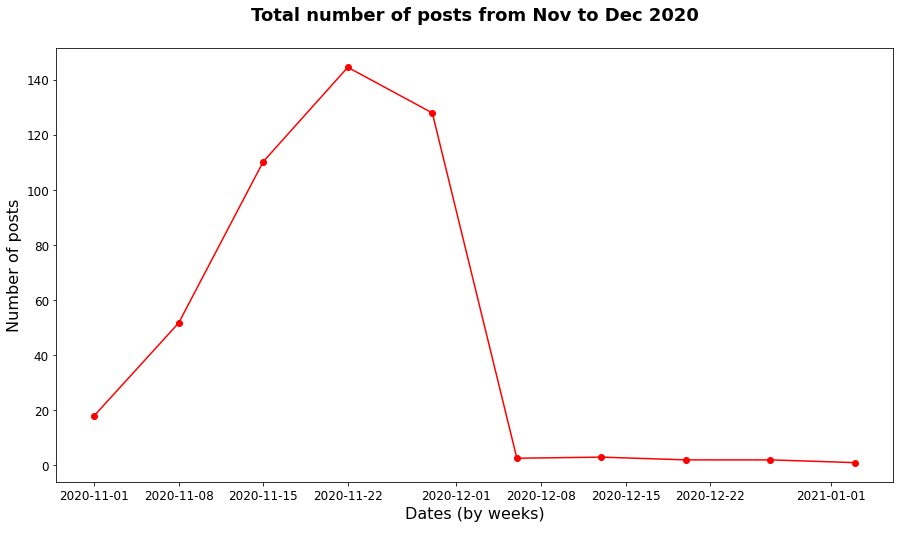

In [124]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(timepost_count_df.post_count.resample('W').mean(), color = 'red', marker = 'o')
ax.set_ylabel("Number of posts", fontsize = 16)
ax.set_xlabel("Dates (by weeks)\n", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.title(("Total number of posts from Nov to Dec 2020" +"\n"), weight = 'bold', fontsize = 18);

In [125]:
test_data_df_trial = test_data_df.copy()

In [126]:
test_data_df_trial["month"] = test_data_df_trial.date_posted.dt.month

In [127]:
test_data_df_trial[test_data_df_trial["month"] == 12].company_name.value_counts()

recruit express    42
equinor             1
Name: company_name, dtype: int64

In [128]:
test_data_df.shape

(2975, 8)

## Job Title

In [129]:
job_title_df = test_data_df[["job_title"]].copy()

In [130]:
job_title_df.job_title = job_title_df.job_title.str.title()

In [131]:
job_title_df['info'] = ""

In [132]:
# To remove #word
reg_exp = r'(\#\w.*?\W|\#\w.*?$)'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['#Sgunitedjobs'], 13),
 (['#Ect'], 24),
 (['#Sgup'], 39),
 (['#Sgunitedtraineeships'], 51)]

In [133]:
# To check for remove (word) at the start of sentence
reg_exp = r'^\([\w?\W].*?\)'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['(Until End Jul 2021)'], 356, 'Bank Officer, Lavender --- $1800 Per …'),
 (['(Beauty & Wellness)'], 480, '- Assistant Sales & Operations Manager'),
 (['(103)'], 529, 'Software Engineer'),
 (['(Csa)'], 769, 'Research Developer')]

In [134]:
# To check for remove (word) at the end of sentence
reg_exp = r'\([\w?\W]\)?.+'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['(School Of Computing)'],
  6,
  'Executive/Senior Executive, Graduate Studies'),
 (['(Server Maintenance)'], 9, 'System Administrator'),
 (['(12-Month Contract)'],
  11,
  'Executive, Corporate Communications & Sustainability'),
 (['(Corporate Communications)'], 14, 'Executive Manager/ Manager')]

In [135]:
# To check for remove [word] at the start of sentence
reg_exp = r'^\[[\w?\W].*?\]'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['[Lush Aesthetics]'], 1493, 'Aesthetic Beauty Consultant'),
 (['[Je]'], 1778, 'Senior Systems Analyst - Eps Consultants Pte Ltd'),
 (['[Internship]'],
  1842,
  'Ctf Program Intern - Government Technology Agency Of Singapore'),
 (['[Js]'], 2183, 'Marketing Specialist')]

In [136]:
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace(u"\u3010", "["))
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace(u"\u3011", "]"))

In [137]:
# To check for remove [word] at the end of sentence
reg_exp = r'\[[\w?\W]\]?.+'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['[$3.5K-$4.2K / Potong Pasir / Sdlc / It Projects] 1322'],
  151,
  'It Business Analyst'),
 (['[$1.5K-$1.6K+Comm+Ot / Tampines] 1322'], 323, 'Manicurist'),
 (['[ C# / Mvc / Javascript / Angular …'], 444, '0386 - Software Engineer'),
 (['[It Domain]'], 600, 'Business Development Manager')]

In [138]:
# To check for remove @words at the end of sentence
reg_exp = r'\@[\w|\W].+'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['@ Jurong East ? Work With …'], 289, '? Online Sales ? Event Packers'),
 (['@ East'], 491, 'Packer'),
 (['@ Global Youthful Lingerie Brand'], 509, 'Temp Retail Assistant $8/Hr'),
 (['@ Tampines'], 535, 'Contract Backend Developers')]

In [139]:
# Remove the words with digits prior to **
reg_exp = r'^[a-zA-Z\s]+\$\d.+\*'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]]

[(['Basic Up$2100 **'],
  2077,
  'Logistics/Warehouse Operations Officer | 5 Days - P-Serv Pte Ltd')]

In [140]:
# Remove the words after **
reg_exp = r'\*{1,}\w.+\*'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['*New*'], 630),
 (['*New*'], 652),
 (['*New*'], 1236),
 (['*Fast Hire*'], 1290)]

In [141]:
# Remove the words with digits prior to |
reg_exp = r'^([a-zA-Z\s]+\$\d.+\|.*?)|^((\W\d).+\|)|^(\d+.\w+.\-)'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += " ".join(symbols[i][0])
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[([('', '', '', '0386 -')], 444, 'Software Engineer'),
 ([('', '', '', '1125 -')], 661, 'Purchaser'),
 ([('', '', '', '1125 -')], 727, 'Architecture Supervisor'),
 ([('', '', '', '0386 -')], 758, 'Sales Engineer')]

In [142]:
# Remove the words after |
reg_exp = r'\|.\w.+'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
job_title_df["job_title"][635] = "Tech Ops Engineer"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['| Up To $7500'], 81),
 (['| Junior Hair Stylist | Senior Hair Stylist | Hairdresser'], 454),
 (['| Oil And Gas Construction |West | $6,300'], 546),
 (['| Tuition Assignment'], 587)]

In [143]:
# Remove the words Ref: digits -
reg_exp = r'Ref:.\d+.\-'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]]

[(['Ref: 121633 -'], 141, 'Associate Director, 3Rd Party Risk Mgmt'),
 (['Ref: 121915 -'], 364, 'Software Engineer - Fullstack Developer'),
 (['Ref: 121431 -'], 442, 'Service Specialist, Backup/Storage Svc')]

In [144]:
# Remove the words with Time
reg_exp = r'\w+\W[T|t]ime'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Full Time'], 149, 'Digital Marketing Freelance Or'),
 (['Part Time'], 193, 'Homebased- 1700'),
 (['Full Time'], 290, 'Cook'),
 (['Part Time'], 304, 'Looking For  Office Cleaners')]

In [145]:
# Remove the words
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('urgent')].index.tolist()), ["info"]] += "Urgent"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace('Urgent', "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('immediate')].index.tolist()), ["info"]] += "Immediate"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Immediate", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('permanent')].index.tolist()), ["info"]] += "Permanent"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Permanent", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('contract')].index.tolist()), ["info"]] += "Contract"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Contract", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('temporary')].index.tolist()), ["info"]] += "Temp"
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('temp')].index.tolist()), ["info"]] += "Temp"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Temporary", "Temp"))
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Temp", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('hour')].index.tolist()), ["info"]] += "Hour"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Hour", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('day')].index.tolist()), ["info"]] += "Day"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Day", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('mth')].index.tolist()), ["info"]] += "Month"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Mth", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('mths')].index.tolist()), ["info"]] += "Month"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Mths", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('month')].index.tolist()), ["info"]] += "Month"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Month", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('year')].index.tolist()), ["info"]] += "Year"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Year", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('north')].index.tolist()), ["info"]] += "North"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("North", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('south')].index.tolist()), ["info"]] += "South"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("South", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('east')].index.tolist()), ["info"]] += "East"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("East", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('west')].index.tolist()), ["info"]] += "West"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("West", "").strip())
job_title_df.loc[(job_title_df[job_title_df.job_title.str.lower().str.contains('central')].index.tolist()), ["info"]] += "Central"
job_title_df.job_title = job_title_df.job_title.apply(lambda x: x.replace("Central", "").strip())

In [146]:
# Removed of United traineeship
reg_exp = r'Sgunited.\w+.'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Sgunited Traineeship:'], 893),
 (['Sgunited Traineeship:'], 927),
 (['Sgunited Traineeship '], 1083),
 (['Sgunited Traineeship:'], 1225)]

In [147]:
# Remove the words before -
reg_exp = r'^(\-)|^([a-zA-Z].\d.+\-)|^(\d+\w+.\-)|^(It - )'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += " ".join(symbols[i][0])
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[([('-', '', '', '')], 169),
 ([('', 'Sk11619840 -', '', '')], 172),
 ([('-', '', '', '')], 480),
 ([('', '', '', 'It - ')], 510)]

In [148]:
# Remove the words end -
reg_exp = r'\-\s[\w\s]+$'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
job_title_df["job_title"][573] = "Equity Analyst"
job_title_df["job_title"][596] = "Lecturer"
job_title_df["job_title"][659] = "Software Developer"
job_title_df["job_title"][810] = "Food Stall As"
job_title_df["job_title"][1079] = "Management Associate Trainees"
job_title_df["job_title"][1096] = 'Lead Development UI Developer'
job_title_df["job_title"][1163] = 'Cash Product Development'
job_title_df["job_title"][1167] = "Service Crew"
job_title_df["job_title"][1331] = "Accounts Cum Payroll"
job_title_df["job_title"][1395] = "Head Senior Assistant Director Big Data Solutions Architect"
job_title_df["job_title"][1784] = "Desk Head"
job_title_df["job_title"][1894] = "Hr Generalist"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['- Japan International Market'], 106),
 (['- Apac Marketing Services'], 111),
 (['- Digital Wealth Chapter'], 154),
 (['- 1700'], 193)]

In [149]:
# Remove the words after |
reg_exp = r'\s\-\s\w.+'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] = symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
job_title_df["job_title"][83] = "Technician"
job_title_df["job_title"][482] = "Assistant Vice President"
job_title_df["job_title"][505] = "Senior Lender Director"
job_title_df["job_title"][945] = "Asia Regional Account Manager Head"
job_title_df["job_title"][1145] = "C++ Developer"
job_title_df["job_title"][1262] = "Principal English Teacher Chinese Teacher"
job_title_df["job_title"][1742] = "Quality Assurance Associate Analyst"
job_title_df["job_title"][2236] = "Security Officer"
job_title_df["job_title"][2371] = "Senior Specialist Order Management Specialist"
job_title_df["job_title"][2744] = "Technician"
job_title_df["job_title"][2954] = "Entry Cpl/Sgt"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[([' - Technician'], 83),
 ([' - Investment & Trading Platform'], 86),
 ([' - Coordinate-Measuring Machine'], 185),
 ([' - Fac Upw & Wwtp'], 194)]

In [150]:
# Remove the digits with X
reg_exp = r'X\d+|X.\d+|\d+X|\d+.X'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['X3'], 416), (['X 2'], 584), (['X3'], 597), (['X5'], 800)]

In [151]:
# Remove numbers
reg_exp = r'\w*\d+\w+|[\$\d]+[\-\/]\w+|[0-9]'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_title_df['info'][i] += symbols[i][0]
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"",x).strip())
[(symbols[i], i, job_title_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['2D'], 13, 'Artist/Animator'),
 (['10'], 42, 'Supermarket Retail Assistant/Cashier / $ Per  / Islandwide'),
 (['T24'], 113, 'Temenos  Technical Solution Architect And Technical …'),
 (['4'], 128, 's Customer Service Officers')]

In [152]:
# Removal of repetition demarketer symbols
count = 0

for index, posts in enumerate(job_title_df.job_title):
    for letter in set(posts.replace(" ", "")):
        if letter.isdigit() == False:
            if letter.isalpha() == False:
                if posts.count(letter)>2:
                    for i in range(len(posts)-1):
                        if posts[i] == letter:
                            count+=1
                            if count == 3:
                                job_title_df["job_title"][index] = posts[0:i].strip()
                                count = 0
                                break
                else:
                    continue

In [153]:
# Removal of single character
for index, posts in enumerate(job_title_df.job_title):
    paragraph = posts.split()
    for posting in paragraph:
        if len(posting.strip()) == 1:
            paragraph.remove(posting)
    job_title_df["job_title"][index] = " ".join(paragraph)

In [154]:
# Remove emojis
emoji_list = re.compile("[""\U00002B50-\U00002BFF" #Stars
                        '\U00002600-\U000026FF' # Miscellaneous Symbols eg Weather, Map
                        '\U00002700-\U000027BF' # Dingbats
                        "\U0001FA00-\U0001FAFF" # Symbols and Pictographs Extended
                        "\U0001F1E0-\U0001F1FF" # Letters
                        "\U0001F300-\U0001F5FF" # Symbols and Pictographs
                        "\U0001F600-\U0001F67F" # Emoticons + Ornaments Dingbats
                        "\U0001F680-\U0001F6FF" # Transport and Map Symbols
                        "\U0001F700-\U0001F7FF" # Alchemical Symbols + Geometric Shape Extended
                        "\U0001F800-\U0001F8FF" # Arrows-C
                        "\U0001F900-\U0001F9FF" # Symbols and Pictographs
                       "\U00003010-\U00003011""]+", flags=re.UNICODE)
symbols = job_title_df['job_title'].apply(lambda x:emoji_list.findall(x))
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:emoji_list.sub(r"",x))
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['⚡'], 2811), (['❤'], 2886), (['❤', '❤'], 2912), (['✪'], 2944)]

In [155]:
# Remove punctuations
def punctuation_removal(text):
    for characters in string.punctuation:
        text = text.replace(characters, " ")
    return text

job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:punctuation_removal(x).strip())

In [156]:
# Missing data
job_title_df[job_title_df["job_title"] == ""]

,job_title,info
437,,100
501,,️100
574,,️100
935,,#Sgunitedjobs
1853,,#Sgunited][ Business Intelligence Trainee - Mo...
1964,,"(School Environment / Towner Rd / Up To $2,450..."
2564,,- Recruitment Express️100
2884,,[Night Shift]X 200$850/Hr
2948,,(32Hrs)Full Time


* Two job_titles have no job titles/positions

In [157]:
# Fill in the missing data
job_title_df["job_title"][437] = "Sales Personnel"
job_title_df["job_title"][501] = "Sales Service Personnel"
job_title_df["job_title"][574] = "Sales Personnel"
job_title_df["job_title"][1853] = "Business Intelligence Trainee"
job_title_df["job_title"][1964] = "Security Officer"
job_title_df["job_title"][2564] = "Sales Personnel"
job_title_df["job_title"][2884] = "Camera Operators"

In [158]:
# Adjustment to normalize
job_title_df["job_title"][19] = "Dishwasher"

In [159]:
# Removal of special characters
job_title_df["job_title"][1270] = job_title_df["job_title"][1270].replace("现场经理", "").strip()

In [160]:
# Extracting acryonyms
acronym_words = set()

for posts in job_title_df.job_title:
    sentence = posts.split()
    for word in sentence:
        if len(word)<5:
            acronym_words.add(word.lower())

list(acronym_words)[:5]

['jobs', 'iit', 'keg', 'from', 'cdd']

In [161]:
# Normalized acronyms
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Sr", "Senior").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Snr", "Senior").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Cum", "And").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Asst", "Assistant").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Dev ", "Development ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("App ", "Applications ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Ops ", "Operations ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Hr ", "Human Resources ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Admin ", "Administrative ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Lab ", "Laboratory ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Mfg ", "Manufacturing ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Avp ", "Assistant Vice President ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Vp ", "Vice President ").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Mgmt", "Management").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Cfo", "Chief Financial Officer").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Ceo", "Chief Executive Officer").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Ehs", "Environment Health Safety").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Hse", "Health Safety Environment").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Devops ", "Development Operations").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("It ", "Information Technology").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Soc ", "Security Operations Center").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("NetworkDeveloper ", "Network Developer").strip())
job_title_df["job_title"] = job_title_df['job_title'].apply(lambda x: x.replace("Wsh ", "Workplace Safety and Health").strip())
job_title_df["job_title"][61] = job_title_df['job_title'][61].replace("Exe", "Executive").strip()
job_title_df["job_title"][1189] = job_title_df['job_title'][1189].replace("Exe", "Executive").strip()
job_title_df["job_title"][2797] = job_title_df['job_title'][2797].replace("Exe", "Executive").strip()
job_title_df["job_title"][901] = job_title_df['job_title'][901].replace("Exec", "Executive").strip()
job_title_df["job_title"][993] = job_title_df['job_title'][993].replace("Exec", "Executive").strip()
job_title_df["job_title"][31] = job_title_df['job_title'][31].replace("Tech ", "Technical ").strip()
job_title_df["job_title"][526] = job_title_df['job_title'][526].replace("Tech ", "Technical ").strip()
job_title_df["job_title"][635] = job_title_df['job_title'][635].replace("Tech ", "Technical ").strip()
job_title_df["job_title"][786] = job_title_df['job_title'][786].replace("Tech ", "Technical ").strip()
job_title_df["job_title"][2075] = job_title_df['job_title'][2075].replace("Tech ", "Technician ").strip()
job_title_df["job_title"][2486] = job_title_df['job_title'][2486].replace("Tech ", "Technician ").strip()
job_title_df["job_title"][999] = job_title_df['job_title'][999].replace("Rep", "Representative").strip()
job_title_df["job_title"][2317] = job_title_df['job_title'][2317].replace("Rep", "Representative").strip()
job_title_df["job_title"][2833] = job_title_df['job_title'][2833].replace("Rep", "Representative").strip()

In [162]:
job_title_df["job_title"][1254] = 'Applications Development Intermediate Programmer Analyst'
job_title_df["job_title"][160] = 'Group Risk Management Collections MIS Analyst'
job_title_df["job_title"][1271] = 'Qa Qc Officer'
job_title_df["job_title"][1446] = 'Environmental Health Safety Officer'

In [163]:
# Replace Net with network
reg_exp = r'Net\s'
symbols = job_title_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
job_title_df['job_title'] = job_title_df['job_title'].apply(lambda x:re.sub(reg_exp,"Network",x).strip())
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]]

[(['Net '], 134),
 (['Net '], 412),
 (['Net '], 445),
 (['Net '], 607),
 (['Net '], 1738),
 (['Net '], 1815),
 (['Net '], 1893),
 (['Net '], 2178),
 (['Net '], 2626)]

## Countvectorizer

In [164]:
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+', gaps=False)

In [165]:
# Tokenize
job_title_df["job_title_tokenize"] = job_title_df["job_title"].apply(lambda post:tokenizer.tokenize(post))
job_title_df.head()

,job_title,info,job_title_tokenize
0,Business Development,(Freight Forwarding),"[Business, Development]"
1,Secretary Pa,,"[Secretary, Pa]"
2,Program Management,,"[Program, Management]"
3,Managing Consultant,,"[Managing, Consultant]"
4,Laboratory Technician,#Erh1700,"[Laboratory, Technician]"


In [166]:
# Removal stopwords
job_title_df["job_title_stopremoval"] = job_title_df["job_title_tokenize"].apply(lambda item:([word for word in item if word not in stopwords.words('english') and len(word)>1]))

In [167]:
# Instiantiate Lemming
lemmatizer = WordNetLemmatizer()

In [168]:
# Lemmatize
job_title_df["job_title_lem"] = job_title_df["job_title_stopremoval"].apply(lambda posts:" ".join([lemmatizer.lemmatize(subposts) for subposts in posts]))

In [169]:
job_title_df.head()

,job_title,info,job_title_tokenize,job_title_stopremoval,job_title_lem
0,Business Development,(Freight Forwarding),"[Business, Development]","[Business, Development]",Business Development
1,Secretary Pa,,"[Secretary, Pa]","[Secretary, Pa]",Secretary Pa
2,Program Management,,"[Program, Management]","[Program, Management]",Program Management
3,Managing Consultant,,"[Managing, Consultant]","[Managing, Consultant]",Managing Consultant
4,Laboratory Technician,#Erh1700,"[Laboratory, Technician]","[Laboratory, Technician]",Laboratory Technician


# Countvectorizer

In [170]:
job_title_lem = job_title_df["job_title_lem"]

In [171]:
job_title_lem.head()

0     Business Development
1             Secretary Pa
2       Program Management
3      Managing Consultant
4    Laboratory Technician
Name: job_title_lem, dtype: object

## ngram_range (1,1)

In [172]:
cvec1 = CountVectorizer(stop_words=("english"), ngram_range = (1,1))

In [173]:
cvec1.fit(job_title_lem)

CountVectorizer(stop_words='english')

In [174]:
job_title_cvec1 = cvec1.transform(job_title_lem)

In [175]:
job_title_cvec1_df = pd.DataFrame(job_title_cvec1.todense(), columns=cvec1.get_feature_names())

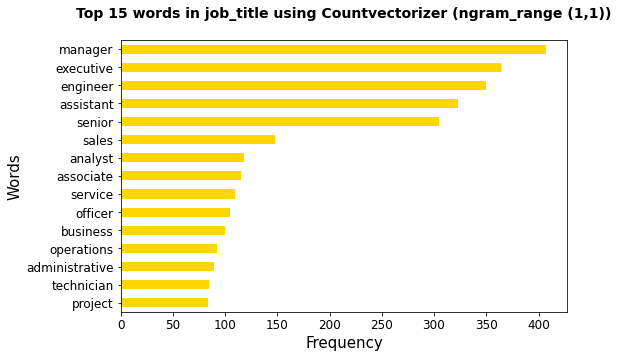

In [176]:
# ngram_range (2,2)
plot_barchat(job_title_cvec1_df.sum().sort_values(ascending=False).head(15)[::-1], "Top 15 words in job_title using Countvectorizer (ngram_range (1,1))\n","Frequency","Words", 'gold')

## ngram_range (2,2) 

In [177]:
cvec2 = CountVectorizer(stop_words=("english"), ngram_range = (2,2))

In [178]:
cvec2.fit(job_title_lem)

CountVectorizer(ngram_range=(2, 2), stop_words='english')

In [179]:
job_title_cvec2 = cvec2.transform(job_title_lem)

In [180]:
job_title_cvec2_df = pd.DataFrame(job_title_cvec2.todense(), columns=cvec2.get_feature_names())

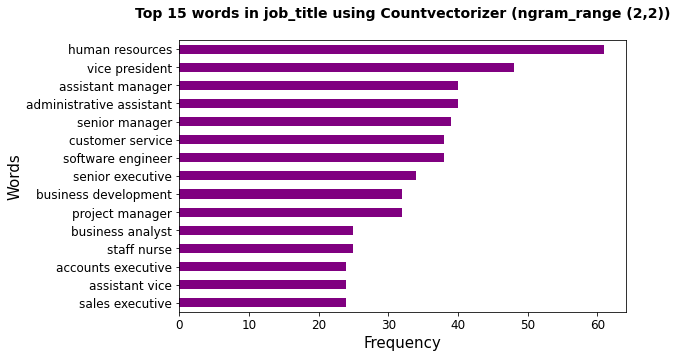

In [181]:
# ngram_range (2,2)
plot_barchat(job_title_cvec2_df.sum().sort_values(ascending=False).head(15)[::-1], "Top 15 words in job_title using Countvectorizer (ngram_range (2,2))\n","Frequency","Words", 'purple')

# Jobs posting without positions

In [182]:
job_posting_lem = job_title_df["job_title_lem"]

In [183]:
position_list = ["Assistant", "Associate", "Head", "Lead", "Leader", "Manager", "President", "Specialist", "Executive", "Intern", "Director", "Vice", "Senior", "Junior", "Chief", "Officer", "Consultant", "Supervisor", "Trainer", "Trainee"]

for position in position_list:
    for index, jobs in enumerate(job_posting_lem):
        if position in jobs:
            job_posting_lem[index] = job_posting_lem[index].replace(position, "").strip()

In [184]:
job_posting_lem.head()

0     Business Development
1             Secretary Pa
2       Program Management
3                 Managing
4    Laboratory Technician
Name: job_title_lem, dtype: object

### ngram_range (1,1)

In [185]:
cvec3 = CountVectorizer(stop_words=("english"), ngram_range = (1,1))

In [186]:
cvec3.fit(job_posting_lem)

CountVectorizer(stop_words='english')

In [187]:
job_posting_cv3 = cvec3.transform(job_posting_lem)

In [188]:
job_posting_cv3_df = pd.DataFrame(job_posting_cv3.todense(), columns=cvec3.get_feature_names())

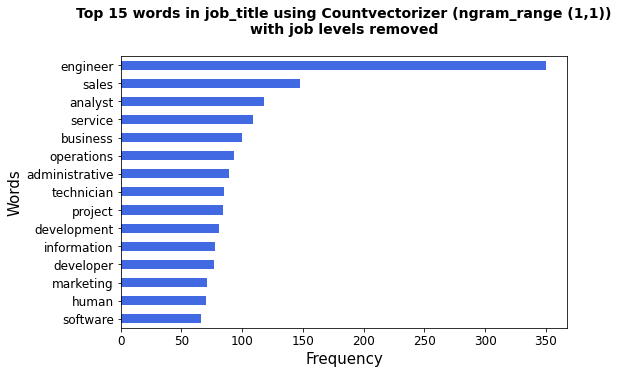

In [189]:
# ngram_range (1,1)
plot_barchat(job_posting_cv3_df.sum().sort_values(ascending=False).head(15)[::-1], "Top 15 words in job_title using Countvectorizer (ngram_range (1,1))\nwith job levels removed\n","Frequency","Words", 'royalblue')

### ngram (2,2)

In [190]:
cvec4 = CountVectorizer(stop_words=("english"), ngram_range = (2,2))

In [191]:
cvec4.fit(job_posting_lem)

CountVectorizer(ngram_range=(2, 2), stop_words='english')

In [192]:
job_posting_cv4 = cvec4.transform(job_posting_lem)

In [193]:
job_posting_cv4_df = pd.DataFrame(job_posting_cv4.todense(), columns=cvec4.get_feature_names())

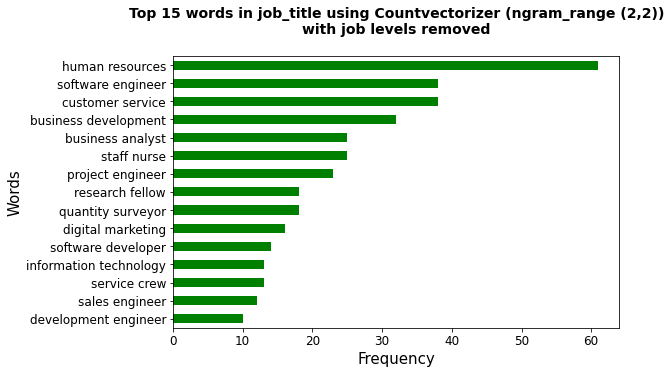

In [194]:
# ngram_range (2,2)
plot_barchat(job_posting_cv4_df.sum().sort_values(ascending=False).head(15)[::-1], "Top 15 words in job_title using Countvectorizer (ngram_range (2,2))\nwith job levels removed\n","Frequency","Words", 'green')

## Type of employment

### Extraction of info

* Job title
* Job description

**Two sections**
* Job time - Full-time, Part-time, shift, night(shift)
* Job time - Permanent/Perm, Contract, temp/temporary, trainee,  intern 

In [195]:
job_info_df = test_data_df.copy()

In [196]:
job_info_df.loc[:,["term"]] = ""
job_info_df.loc[:,["time"]] = ""

In [197]:
job_info_df.shape

(2975, 10)

In [198]:
# Full time in job_title
reg_exp = r'[F|f]ull\W[T|t]ime'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_info_df.loc[[i],['time']] += " full_time"
[(symbols[i], i, job_info_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['full time'], 149, 'Digital Marketing freelance or full time'),
 (['Full Time'], 290, 'Full Time Cook'),
 (['Full-Time'], 478, 'Retail Sales Assistants (Part/Full-Timers)'),
 (['Full Time'],
  513,
  'ICG Technology Software Development, 2021 Full Time Analyst, Singapore')]

In [199]:
# Full time in job_description
reg_exp = r'[F|f]ull\W[T|t]ime'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " full_time":
                job_info_df.loc[[i],['time']] += " full_time"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['full-time', 'full-time'], 15),
 (['Full-time'], 45),
 (['full time'], 59),
 (['Full-time'], 99)]

In [200]:
# Part time in job_title
reg_exp = r'[P|p]art\W[T|t]ime'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            job_info_df.loc[[i],['time']] += " part_time"
[(symbols[i], i, job_info_df['job_title'][i]) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Part Time'], 304, 'Looking for Part Time Office Cleaners'),
 (['Part Time'], 385, 'Part Time Services crew'),
 (['Part Time'], 586, 'Part Time - Server'),
 (['Part Time'],
  810,
  'Looking for Full Timer / Part Timer Hourly 7.50 - Food Stall As')]

In [201]:
# Part time in job_description
reg_exp = r'[P|p]art\W[T|t]ime'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " part_time":
                job_info_df.loc[[i],['time']] += " part_time"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['part time'], 59),
 (['part time'], 271),
 (['part-time', 'Part-time'], 294),
 (['Part-Time', 'part-time'], 304)]

In [202]:
# Shift in job_title
reg_exp = r'[S|s]hift\W'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " shift":
                job_info_df.loc[[i],['time']] += " shift"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Shift '], 723), (['Shift '], 854), (['Shift)'], 861), (['Shift)'], 1135)]

In [203]:
# Shift in job_description
reg_exp = r'[S|s]hift\W'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " shift":
                job_info_df.loc[[i],['time']] += " shift"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Shift '], 83), (['shift '], 109), (['shift<'], 126), (['shift '], 140)]

In [204]:
# Night in job_title
reg_exp = r'[N|n]ight'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " shift":
                job_info_df.loc[[i],['time']] += " shift"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Night'], 980), (['night'], 1526), (['night'], 1844), (['night'], 2328)]

In [205]:
# Night in job_description
reg_exp = r'[N|n]ight'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['time'][i] != " shift":
                job_info_df.loc[[i],['time']] += " shift"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['night'], 44),
 (['night'], 287),
 (['night', 'night', 'Night', 'Night'], 289),
 (['night'], 348)]

In [206]:
# Permanent/Perm in job_title
reg_exp = r'[P|p]ermanent|[P|p]erm\W'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " permanent":
                job_info_df.loc[[i],['term']] += " permanent"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Perm/'], 680),
 (['Perm '], 836),
 (['Permanent'], 1167),
 (['Permanent'], 1257)]

In [207]:
# Permanent/Perm in job_description
reg_exp = r'[P|p]ermanent|[P|p]erm\W'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " permanent":
                job_info_df.loc[[i],['term']] += " permanent"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['permanent'], 34),
 (['Permanent'], 45),
 (['permanent'], 53),
 (['permanent'], 81)]

In [208]:
# Temporary/Temp in job_title
reg_exp = r'[T|t]emporary|[T|t]emp\W'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " temporary":
                job_info_df.loc[[i],['term']] += " temporary"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Temp '], 278), (['Temp '], 450), (['Temp '], 509), (['Temp '], 524)]

In [209]:
# Temporary/Temp in job_description
reg_exp = r'[T|t]emporary|[T|t]emp\W'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " temporary":
                job_info_df.loc[[i],['term']] += " temporary"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['temporary', 'temporary'], 81),
 (['Temporary'], 122),
 (['temporary'], 185),
 (['Temp '], 278)]

In [210]:
# Contract in job_title
reg_exp = r'[C|c]ontract'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " contract":
                job_info_df.loc[[i],['term']] += " contract"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['contract'], 20),
 (['contract'], 38),
 (['Contract'], 76),
 (['Contract'], 89)]

In [211]:
# Contract in job_description
reg_exp = r'[C|c]ontract'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " contract":
                job_info_df.loc[[i],['term']] += " contract"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['contract'], 3),
 (['Contract', 'contract', 'contract'], 7),
 (['contract'], 16),
 (['Contract'], 18)]

In [212]:
# Intern in job_title
reg_exp = r'[I|i]ntern\W'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " intern":
                job_info_df.loc[[i],['term']] += " intern"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Intern,'], 689),
 (['Intern,'], 773),
 (['Intern '], 1116),
 (['Intern '], 1281)]

In [213]:
# Intern in job_description
reg_exp = r'[I|i]ntern\W'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " intern":
                job_info_df.loc[[i],['term']] += " intern"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Intern '], 244),
 (['Intern ', 'Intern ', 'Intern '], 547),
 (['Intern '], 622),
 (['Intern '], 635)]

In [214]:
# Trainee in job_title
reg_exp = r'[T|t]rainee\W|[T|t]rainees\W'
symbols = job_info_df['job_title'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " trainee":
                job_info_df.loc[[i],['term']] += " trainee"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Trainee,'], 162),
 (['Trainee '], 325),
 (['Trainee '], 384),
 (['Trainee)'], 634)]

In [215]:
# Trainee in job_description
reg_exp = r'[T|t]rainee\W|[T|t]rainees\W'
symbols = job_info_df['job_description'].apply(lambda x:re.findall(reg_exp,x))
for i in range(len(symbols)):
     if symbols[i]!=[]:
            if job_info_df['term'][i] != " trainee":
                job_info_df.loc[[i],['term']] += " trainee"
[(symbols[i], i) for i in range(len(symbols)) if symbols[i]!=[]][1:5]

[(['Trainee '], 97),
 (['Trainee,', 'Trainee ', 'Trainees ', 'Trainee '], 108),
 (['Trainee ', 'Trainee '], 143),
 (['Trainee ', 'Trainee ', 'Trainee ', 'Trainees '], 162)]

## Job_term

In [216]:
job_term_df = job_info_df[["term"]]

In [218]:
job_term_df.loc[:,["contract"]] = 0
job_term_df.loc[:,["permanent"]] = 0
job_term_df.loc[:,["temporary"]] = 0
job_term_df.loc[:,["intern"]] = 0
job_term_df.loc[:,["trainee"]] = 0

In [219]:
for contract_num in range(len(job_term_df.term)):
    if 'contract' in job_term_df.term[contract_num]:
        job_term_df.loc[[contract_num], ["contract"]] = 1

for permanent_num in range(len(job_term_df.term)):
    if 'permanent' in job_term_df.term[permanent_num]:
        job_term_df.loc[[permanent_num], ["permanent"]] = 1
        
for temporary_num in range(len(job_term_df.term)):
    if 'temporary' in job_term_df.term[temporary_num]:
        job_term_df.loc[[temporary_num], ["temporary"]] = 1

for trainee_num in range(len(job_term_df.term)):
    if 'trainee' in job_term_df.term[trainee_num]:
        job_term_df.loc[[trainee_num], ["trainee"]] = 1

for intern_num in range(len(job_term_df.term)):
    if 'intern' in job_term_df.term[intern_num]:
        job_term_df.loc[[intern_num], ["intern"]] = 1

In [220]:
job_term_plot = job_term_df.drop("term", axis = 1)

In [221]:
job_term_plot.sum().sort_values(ascending = False)

contract     596
permanent    201
temporary    121
trainee       85
intern        18
dtype: int64

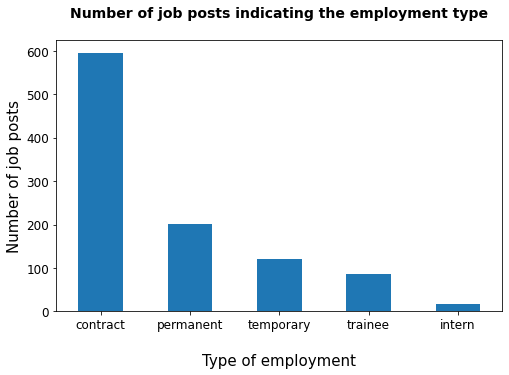

In [222]:
job_term_plot.sum().sort_values(ascending = False).plot(kind='bar', figsize = (8,5), rot=0)
plt.xlabel("\nType of employment", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel("Number of job posts", fontsize = 15)
plt.title("Number of job posts indicating the employment type\n", fontsize = 14, weight = 'bold');

## Job_time

In [223]:
job_time_df = job_info_df[["time"]]

In [224]:
job_time_df.loc[:,["full_time"]] = 0
job_time_df.loc[:,["part_time"]] = 0
job_time_df.loc[:,["shift"]] = 0

In [225]:
for full_time_num in range(len(job_time_df.time)):
    if 'full_time' in job_time_df.time[full_time_num]:
        job_time_df.loc[[full_time_num], ["full_time"]] = 1

for part_time_num in range(len(job_time_df.time)):
    if 'part_time' in job_time_df.time[part_time_num]:
        job_time_df.loc[[part_time_num], ["part_time"]] = 1
        
for shift_num in range(len(job_time_df.time)):
    if 'shift' in job_time_df.time[shift_num]:
        job_time_df.loc[[shift_num], ["shift"]] = 1

In [226]:
job_time_plot = job_time_df.drop("time", axis = 1)

In [227]:
job_time_plot.sum().sort_values(ascending = False)

shift        236
full_time    169
part_time     76
dtype: int64

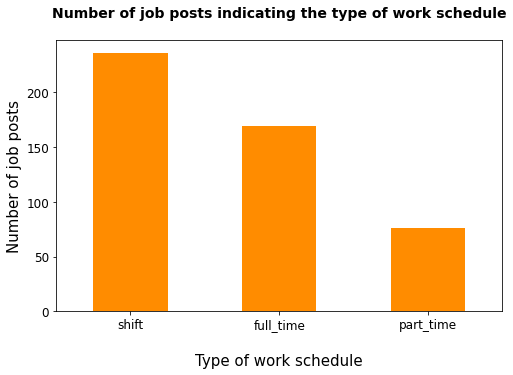

In [228]:
job_time_plot.sum().sort_values(ascending = False).plot(kind='bar', figsize = (8,5), rot=0, color = "darkorange")
plt.xlabel("\nType of work schedule", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel("Number of job posts", fontsize = 15)
plt.title("Number of job posts indicating the type of work schedule\n", fontsize = 14, weight = 'bold');